In [32]:
import networkx as nx
import numpy as np
import pandas as pd 

from ete3 import Tree
import utilities.validate_trees as tree_val

import sys
import os

from tqdm import tqdm_notebook

import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
import matplotlib as mpl

import cassiopeia.TreeSolver.compute_meta_purity as cmp 
from cassiopeia.TreeSolver.Node import Node

from tqdm import tqdm

import scanpy as sc

import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")

In [2]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
# path = '/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/hg19/'
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
#meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/100k_meta.txt", sep='\t', index_col = 0)
#latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
#gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/100k/RNA/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values
adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 8))

In [6]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

In [7]:
meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter, :]

latent = latent.loc[adata.obs_names]

In [ ]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [ ]:
adata = adata[adata.obs.percent_mito < 0.05, :]

In [ ]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [ ]:
sc.tl.pca(adata, n_comps=30)

# Read in trees

In [3]:
def assign_edge_lengths(tree):

    for e in tree.edges():

        tree[e[0]][e[1]]['length'] = e[0].get_mut_length(e[1])
    return tree

labels = []
tree_fps = []
lg_to_tree = {}
i = 0
for tree_dir in tqdm(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.txt" in fp]
    if len(fps) > 0:
#             tree = nx.read_gpickle(tree_dir + fps[0]).get_network()
#             for e in tree.edges():
#                 print(e[0].get_mut_length(e[1]))
            try:
                tree = nx.read_gpickle(tree_dir + fps[0]).get_network()
                lg_to_tree[int(lg)] = assign_edge_lengths(tree)
                tree_fps.append(tree_dir + fps[0])
                cmfp = tree_dir + cmfp[0]
                labels.append(int(lg))
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
            except:
                i += 1

100%|██████████| 113/113 [00:03<00:00, 33.58it/s]


In [4]:
cm = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg3/lg3_character_matrix.txt", sep='\t', index_col = 0)
print('number of cells: ', cm.shape[0])
print('number of unique cells', cm.drop_duplicates().shape[0])

lg3 = lg_to_tree[3]
root = [n for n in lg3 if lg3.in_degree(n) == 0][0]
lg3 = cmp.set_depth(lg3, root)

tree_depths = [lg3.nodes[n]['depth'] for n in lg3 if lg3.out_degree(n) == 0]
print('avg tree depth', np.mean(tree_depths))


number of cells:  5616
number of unique cells 5560
avg tree depth 15.544159544159545


Creating pairs to compare: 100%|██████████| 305/305 [00:00<00:00, 10408.89it/s]


Finding LCAs for all pairs...
Computing pairwise distances...


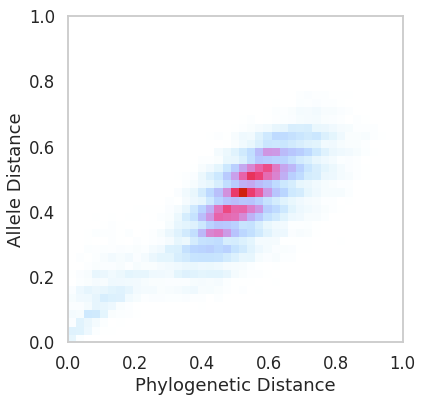

In [19]:
tree = lg_to_tree[19]
subset = [n for n in tree if tree.out_degree(n) == 0 if n.name in adata.obs.index.values]
_leaves = [n.name for n in subset]

tree_dists, edit_dists, all_pairs, diam, n_targets = tree_val.compute_pairwise_dist_nx(tree, subset=subset)
tree_val.dist_plotter(tree_dists, edit_dists/(2*n_targets), '2D-Hist', diam=diam, n_targets = n_targets)

## Compare distances between CNV-resolved and TargetSite-resolved trees

NewickError: Unexisting tree file or Malformed newick tree structure.
You may want to check other newick loading flags like 'format' or 'quoted_node_names'.